In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import jax

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

try:
  import flax
except ModuleNotFoundError:
  !pip install --quiet flax
  import flax

try:
  import optax
except ModuleNotFoundError:
  !pip install --quiet optax
  import optax

try:
  import diffrax
except ModuleNotFoundError:
  !pip install --quiet diffrax
  import diffrax

from flax import linen as nn
from flax.training import train_state

from tqdm import trange
from functools import partial

In [213]:
from typing import NamedTuple, Any

class TimedX(NamedTuple):
  t: Any
  x: jnp.ndarray

def gaussians(jseed, t):
  jseeds = random.split(jseed, 3)
  x_1 = random.randint(jseeds[0], minval=0, maxval=2, shape=(t.shape[0], 2))
  x_1 = x_1.astype(float)-0.5
  x_1 += 1e-1*random.normal(jseeds[1], shape=(t.shape[0],2))
  x_0 = 1e-1*random.normal(jseeds[2], shape=(t.shape[0],2))
  x_t = jnp.sqrt(1-t)*x_0 + jnp.sqrt(t)*x_1
  return x_0, x_1, x_t

def diamonds(jseed, t):
  jseeds = random.split(jseed, 3)
  x_1 = random.randint(jseeds[0], minval=0, maxval=2, shape=(t.shape[0], 2))
  x_1 = x_1.astype(float)-0.5
  x_1 += 5e-1*(random.uniform(jseeds[1], shape=(t.shape[0],2))-0.5)
  x_0 = 5e-1*(random.uniform(jseeds[2], shape=(t.shape[0],2))-0.5)
  x_t = jnp.sqrt(1-t)*x_0 + jnp.sqrt(t)*x_1
  R = jnp.array([[1/math.sqrt(2),-1/math.sqrt(2)],
                 [1/math.sqrt(2),1/math.sqrt(2)]])
  return x_0@R, x_1@R, x_t@R

# DEFINE THE DYNAMICS TO USE HERE
q_t = gaussians

############################## plotting utils ##############################

def plot_dynamics(dynamics, label, axes=None):
  n_cols = len(dynamics)
  if axes is None:
    _, axes = plt.subplots(1,n_cols)
  for i in range(n_cols):
    t = dynamics[i].t
    x_t = dynamics[i].x
    
    axes[i].scatter(x_t[:,0], x_t[:,1], alpha=0.7, label=f'{label}_{t:.2f}')
    axes[i].legend(loc='upper right')
    axes[i].set_xlim(-1.5,1.5)
    axes[i].set_ylim(-1.5,1.5)
    axes[i].set(frame_on=False)
    axes[i].grid(True)
  return axes

In [214]:
seed = 0
np.random.seed(seed)
jseed = random.PRNGKey(seed)
bs = 512
jseed, loc_seed = random.split(jseed)
x_0, x_1, _ = q_t(loc_seed, jnp.ones([bs,1]))
x_t = [TimedX(t=0.0, x=x_0), *[TimedX(t=0.0, x=jnp.array([[[]]]))]*4, TimedX(t=1.0, x=x_1)]

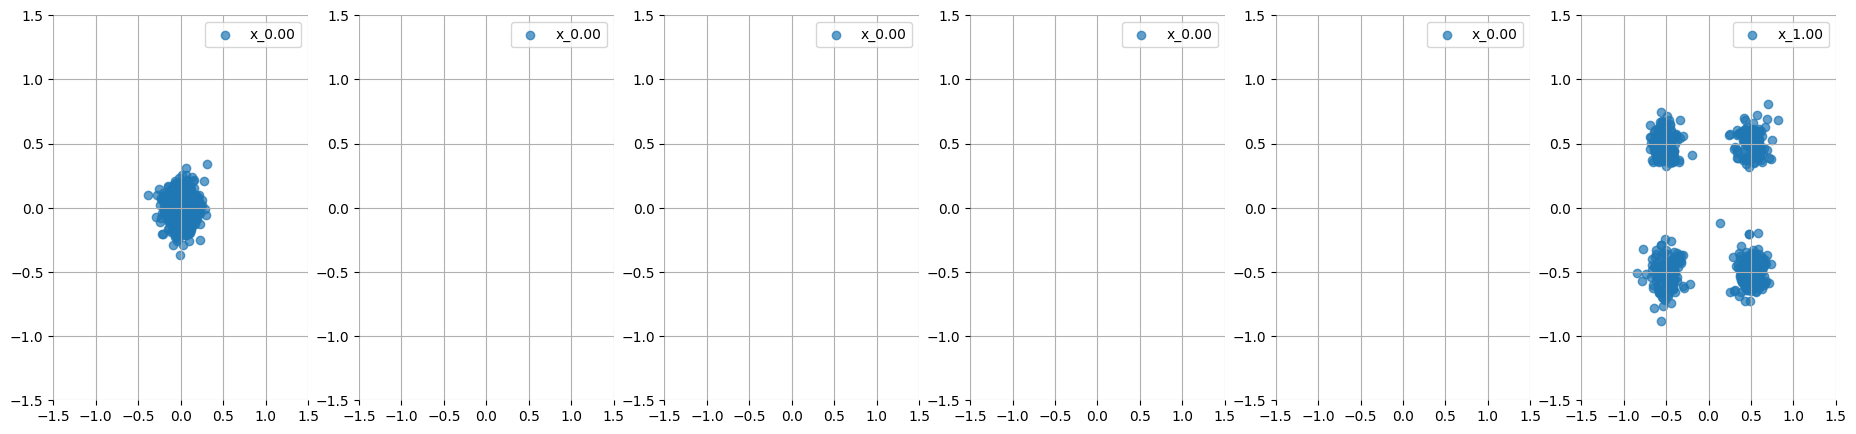

In [215]:
figsize(23,5)
plot_dynamics(x_t, 'x')
plt.show()

In [216]:
class MLP(nn.Module):
  num_hid : int
  num_out : int

  @nn.compact
  def __call__(self, t, x):
    h = jnp.hstack([t,x])
    h = nn.Dense(self.num_hid)(h)
    h = nn.relu(h)
    h = nn.Dense(self.num_hid)(h)
    h = nn.swish(h)
    h = nn.Dense(self.num_hid)(h)
    h = nn.swish(h)
    h = nn.Dense(self.num_out)(h)
    return h

In [217]:
def sample_t(u0, n, t0=0.0, t1=1.0):
  u = (u0 + math.sqrt(2)*jnp.arange(n + 1)) % 1
  u = u.reshape([-1,1])
  return u[:-1]*(t1-t0) + t0, u[-1]

In [218]:
s = MLP(num_hid=512, num_out=1)
q = MLP(num_hid=128, num_out=2)

jseed, *init_seeds = random.split(jseed, 3)
state_s = train_state.TrainState.create(apply_fn=s.apply,
                                        params=s.init(init_seeds[0], x_t[0].t*np.ones([bs,1]), x_t[0].x),
                                        tx=optax.adam(learning_rate=2e-4))

state_q = train_state.TrainState.create(apply_fn=q.apply,
                                        params=q.init(init_seeds[1], x_t[0].t*np.ones([bs,1]), x_t[0].x),
                                        tx=optax.adam(learning_rate=2e-4))

# derivatives of the model that we need to define the loss
def V(t, x, p):
  dsdtdx_fn = jax.grad(lambda t, x, p: state_s.apply_fn(p,t,x).sum(), argnums=[0,1])
  dsdt, dsdx = dsdtdx_fn(t, x, p)
  return dsdt + 0.5*(dsdx**2).sum(1, keepdims=True)
dVdx_fn = jax.grad(lambda t, x, p: V(t,x,p).sum(), argnums=1)
# and to apply the model
dsdx_fn = jax.jit(jax.grad(lambda t, x, p: state_s.apply_fn(p,t,x).sum(), argnums=1))

In [219]:
def loss_fn(state_s, state_q, params_s, params_q, bs, u0, key):
  keys = random.split(key)
  t_0, t_1 = jnp.zeros([bs, 1]), jnp.ones([bs, 1])
  t, u0 = sample_t(u0, bs)
  x_0, x_1, x_t = q_t(keys[0], t)
  x_next = x_t + state_q.apply_fn(params_q, t, x_t)*t*(1-t)
  update = jax.lax.stop_gradient(dVdx_fn(t, x_next, params_s))
  x_next = x_next + 1e-1*update
  x_next = jax.lax.stop_gradient(x_next)

  loss = state_s.apply_fn(params_s, t_0, x_0) - state_s.apply_fn(params_s, t_1, x_1)
  loss += V(t, x_next, params_s)
  loss += -((x_next - (x_t + state_q.apply_fn(params_q, t, x_t)*t*(1-t)))**2).sum(1, keepdims=True)
  return loss.mean(), (jnp.sqrt((update**2).sum(1)).mean(), u0)

@partial(jax.jit, static_argnums=2)
def train_step(state_s, state_q, bs, u0, key):
  grad_fn = jax.value_and_grad(loss_fn, argnums=[2,3], has_aux=True)
  (loss, (gradV, u0)), grads = grad_fn(state_s, state_q, state_s.params, state_q.params, bs, u0, key)
  state_s = state_s.apply_gradients(grads=grads[0])
  state_q = state_q.apply_gradients(grads=jax.tree_map(lambda _dp: -_dp, grads[1]))
  return state_s, state_q, loss, gradV, u0

jseed, loc_seed = random.split(jseed)
_, _, _, _, _ = train_step(state_s, state_q, bs, 0.5, loc_seed)

In [220]:
num_iterations = 10_000
u0 = 0.5

loss_plot = np.zeros(num_iterations)
gradV_plot = np.zeros(num_iterations)
for iter in trange(num_iterations):
  jseed, loc_seed = random.split(jseed)
  state_s, state_q, loss, gradV, u0 = train_step(state_s, state_q, bs, u0, loc_seed)
  loss_plot[iter] = loss
  gradV_plot[iter] = gradV

100%|██████████| 10000/10000 [00:39<00:00, 250.61it/s]


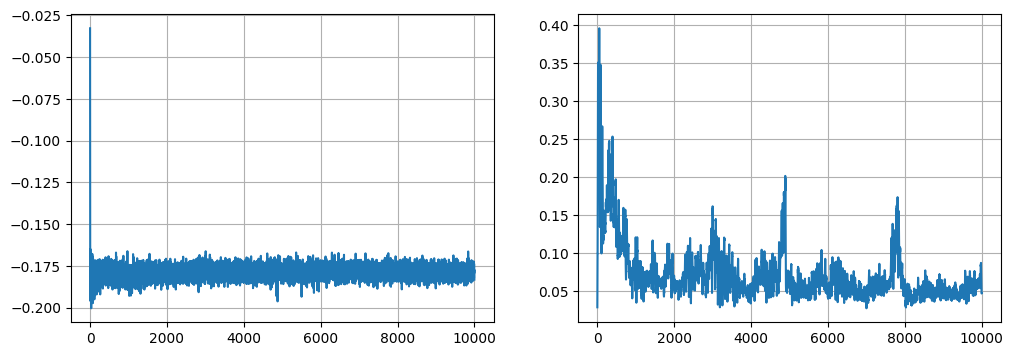

In [226]:
figsize(12,4)
plt.subplot(121)
plt.plot(loss_plot)
plt.grid()
plt.subplot(122)
plt.plot(gradV_plot)
# plt.ylim(0.0, 5.0)
plt.grid()

In [222]:
dt = 1e-2
t_0 = 0.0
n = int(1/dt)
jseed, *loc_seed = random.split(jseed, num=3)
x = [TimedX(t=t_0, x=q_t(loc_seed[0], jnp.zeros([bs,1]))[0])]
for _ in trange(n):
  x_ = x[-1].x + dt*dsdx_fn(x[-1].t*jnp.ones([bs,1]), x[-1].x, state_s.params)
  t_ = x[-1].t + dt
  x.append(TimedX(t=t_, x=x_))
  jseed, loc_seed = random.split(jseed)

100%|██████████| 100/100 [00:00<00:00, 242.75it/s]


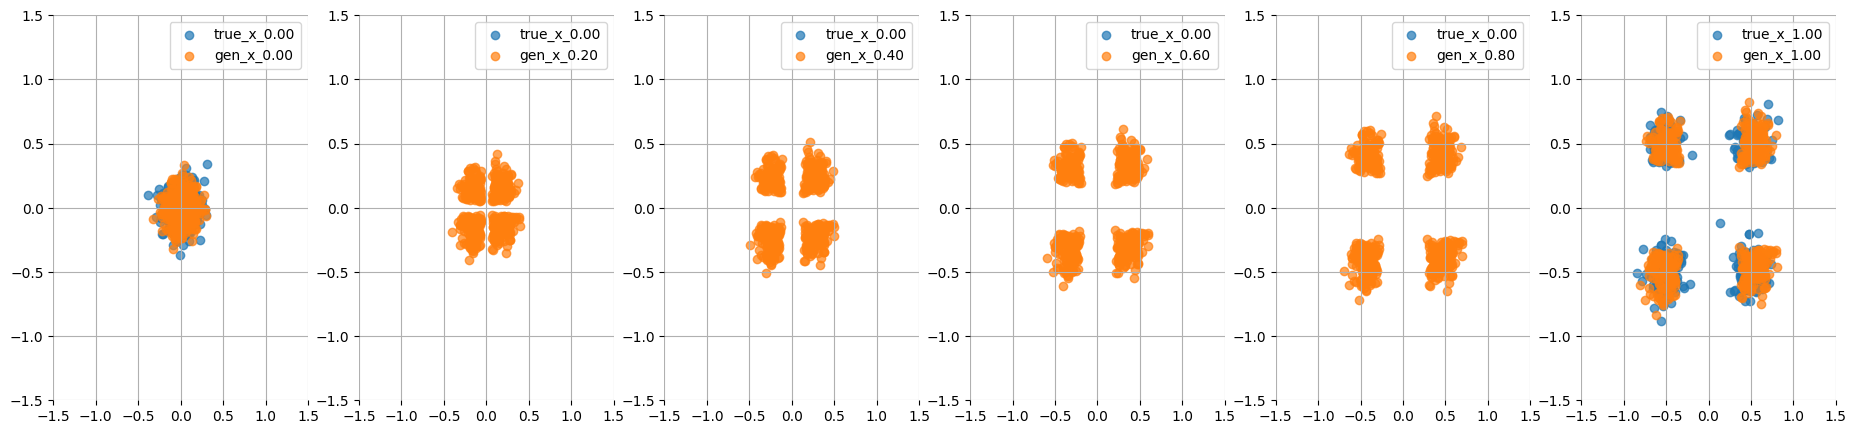

In [223]:
figsize(23,5)
ax = plot_dynamics(x_t, 'true_x')
_ = plot_dynamics(x[::20], 'gen_x', ax)
plt.show()

In [224]:
dt = 1e-2
t_0 = 0.0
n = int(1/dt)
jseed, loc_seed = random.split(jseed)
x = [TimedX(t=t_0, x=q_t(loc_seed, np.zeros([bs,1]))[0])]
x.extend([TimedX(t=0.0, x=jnp.array([[[]]]))]*4)
x.append(TimedX(t=1.0, x=x[0].x + dsdx_fn(x[0].t*jnp.ones([bs,1]), x[0].x, state_s.params)))

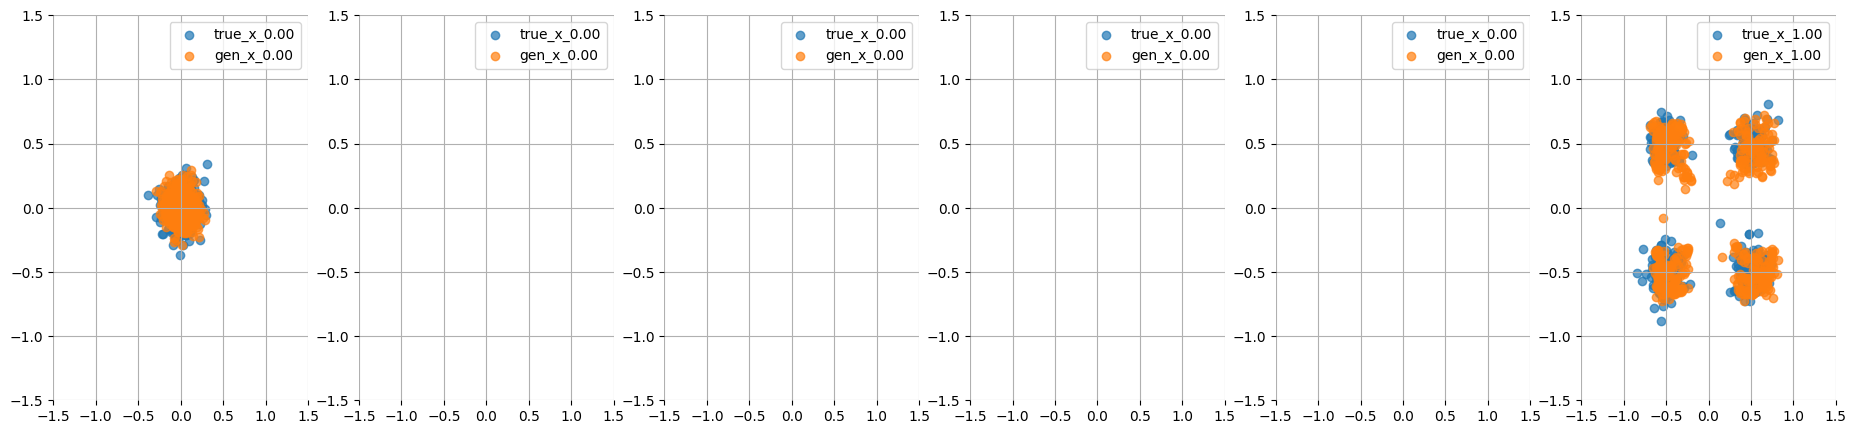

In [225]:
figsize(23,5)
ax = plot_dynamics(x_t, 'true_x')
_ = plot_dynamics(x, 'gen_x', ax)
plt.show()